Files already downloaded and verified
Files already downloaded and verified


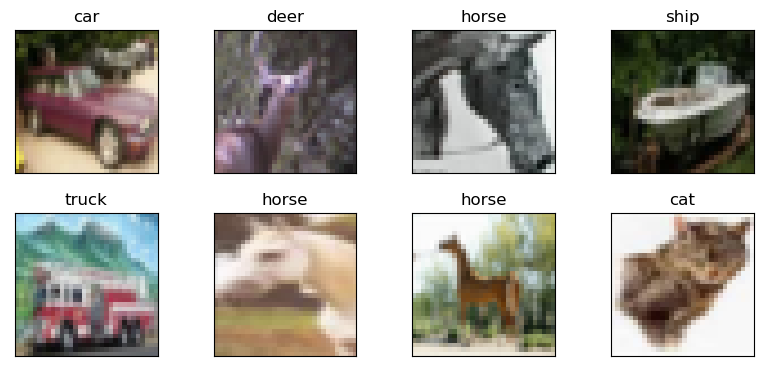

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import numpy as np
from tqdm.auto import tqdm, trange

from misc import *

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='data/__cache__', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='data/__cache__', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


images, labels = next(iter(trainloader))

fig = plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.tight_layout()
    img = images[i]
    img = img / 2 + 0.5
    img = np.transpose(img, (1,2,0))
    plt.imshow(img, interpolation='nearest')
    plt.title("{}".format(classes[labels[i]]))
    plt.xticks([])
    plt.yticks([])

In [2]:

class ConvNet(nn.Module):
    def __init__(self, n_way):
        
        super(ConvNet, self).__init__()
         
        self.flatten = nn.Flatten()
        
        self.conv_layers = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        h = x
        h = self.conv_layers(h)
        h = self.flatten(h)
        h = self.fc_layers(h)
        return h
    
    
    
model = ConvNet(n_way=10)
num_params = sum(p.numel() for p in model.parameters())
print(model)
cprint('r', 'Total params: {:.3f}M'.format(num_params/(1e6)))


ConvNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1

In [3]:
device='cuda:0'

epochs=100
lr=1e-3
reg=1e-5

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

def metric_accuracy_logits(model, dataset, device, batchsz=100):

    data_loader = DataLoader(dataset=dataset, batch_size=batchsz, shuffle=True, drop_last=False)
    acc_corr = 0
    
    with torch.no_grad():
        
        for batch_idx, (X, y) in enumerate(data_loader):
            
            X = X.float().to(device)
            y = y.long().to(device)
    
            logits = model(X)
            yhat = logits.argmax(1)
            corr = torch.eq(yhat, y).int().sum()
            acc_corr+=corr.item()
        #
        
        return acc_corr/len(dataset)

    
model.to(device)
hist_loss = []

for ie in tqdm(range(epochs+1)):
    
    for batch_idx, (images, labels) in enumerate(trainloader):
        images = images.float().to(device)
        labels = labels.long().to(device)
        
        pred = model(images)
        loss = loss_fn(pred, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        hist_loss.append(loss.item())
    #
    
    acc_tr = metric_accuracy_logits(model, trainset, device)
    acc_te = metric_accuracy_logits(model, testset, device)
    
    cprint('r', 'Epoch #{}\t: '.format(ie), end='')
    print('loss={:.5f}, train_acc={:.3f}, test_acc={:.3f}'.format(loss.item(), acc_tr, acc_te))
    
    
hist_loss = np.array(hist_loss)   
    

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch #0	: loss=1.39337, train_acc=0.570, test_acc=0.559
Epoch #1	: loss=1.12422, train_acc=0.689, test_acc=0.670
Epoch #2	: loss=1.76324, train_acc=0.694, test_acc=0.669
Epoch #3	: loss=0.99260, train_acc=0.757, test_acc=0.719
Epoch #4	: loss=0.85370, train_acc=0.794, test_acc=0.750
Epoch #5	: loss=0.43209, train_acc=0.808, test_acc=0.760
Epoch #6	: loss=0.37179, train_acc=0.831, test_acc=0.766
Epoch #7	: loss=0.41356, train_acc=0.838, test_acc=0.779
Epoch #8	: loss=0.36301, train_acc=0.829, test_acc=0.760
Epoch #9	: loss=0.04297, train_acc=0.874, test_acc=0.791
Epoch #10	: loss=0.27860, train_acc=0.879, test_acc=0.790
Epoch #11	: loss=0.34069, train_acc=0.880, test_acc=0.788
Epoch #12	: loss=0.29341, train_acc=0.899, test_acc=0.791
Epoch #13	: loss=0.54510, train_acc=0.903, test_acc=0.795
Epoch #14	: loss=0.68853, train_acc=0.918, test_acc=0.804
Epoch #15	: loss=0.21301, train_acc=0.919, test_acc=0.798
Epoch #16	: loss=0.38249, train_acc=0.928, test_acc=0.806
Epoch #17	: loss=0.82869

Text(0, 0.5, 'Cross Entroty Loss')

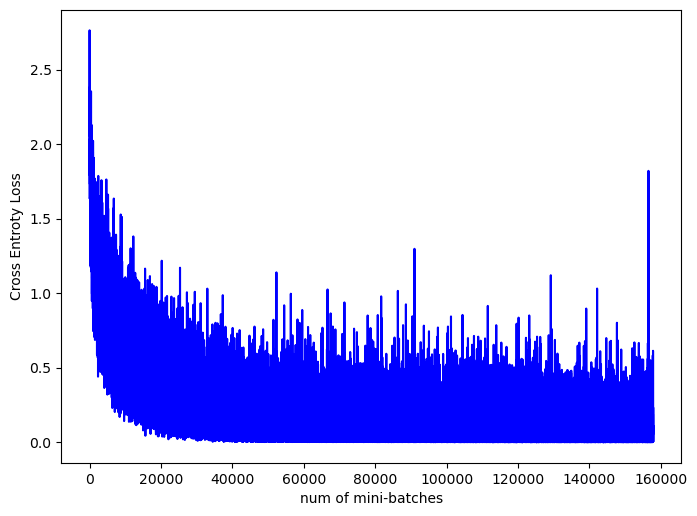

In [4]:
fig = plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
hist = np.arange(hist_loss.size)

plt.plot(hist, hist_loss, color='b')
plt.xlabel('num of mini-batches')
plt.ylabel('Cross Entroty Loss')